In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print(tf.version)
print(tf.keras.__version__)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>
2.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks'


/content/drive/My Drive/Colab Notebooks


In [ ]:
# load numpy array from npy file
from numpy import load
# load array
data = load('fmnist_train.npy', allow_pickle=True).item()
testdata = load('fmnist_test.npy', allow_pickle=True).item()

In [ ]:
x_train1 = data['features'].reshape([60000, 28*28])
y_train1 = data['target'].astype(int) - 1

x_test1 = testdata['features'].reshape([10000, 28*28])

In [ ]:
# split the training data into train and validate arrays (will be used later)
from sklearn.model_selection import train_test_split

x_train, x_validate, y_train, y_validate = train_test_split(
    x_train1, y_train1, test_size=0.4, random_state=12345,
)

x_test, x_validate, y_test, y_validate = train_test_split(
    x_validate, y_validate, test_size=0.5, random_state=12345,
)

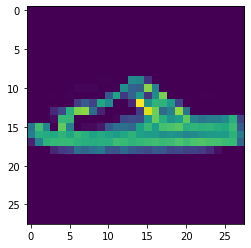

In [ ]:
# lets see what the images look like
image = x_train[500, :].reshape((28, 28))

plt.imshow(image)
plt.show()

## Create the CNN

*   Define the model
* Compile the model
* Fit the model



In [ ]:
im_rows = 28
im_cols = 28
batch_size = 512
im_shape = (im_rows, im_cols, 1)

x_train = x_train.reshape(x_train.shape[0], *im_shape)
x_test = x_test.reshape(x_test.shape[0], *im_shape)
x_validate = x_validate.reshape(x_validate.shape[0], *im_shape)

print('x_train shape: {}'.format(x_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('x_validate shape: {}'.format(x_validate.shape))


x_train shape: (36000, 28, 28, 1)
x_test shape: (12000, 28, 28, 1)
x_validate shape: (12000, 28, 28, 1)


In [ ]:
#Defining constants
epochs = 50
batch_size = 512
data_augmentation = False
img_size = 28

num_classes = 5
num_filters = 64
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False

In [ ]:
#Creating model based on ResNet published archietecture
inputs = Input(shape=im_shape)
x = Conv2D(num_filters, padding='same', 
           kernel_initializer='he_normal', 
           kernel_size=7, strides=2,
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

#Check by applying max pooling later (setting it false as size of image is small i.e. 28x28)
if use_max_pool:
    x = MaxPooling2D(pool_size=3,padding='same', strides=2)(x)
    num_blocks =3
#Creating Conv base stack 

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        #Creating residual mapping using y
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)   
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        #Adding back residual mapping
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters

# Add classifier on top.
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

# Instantiate and compile model.
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 14, 14, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
import os
save_dir = os.path.join(os.getcwd(), 'saved_model')
model_name = 'fmnist_resnet_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir,model_name)
print(filepath)

# Prepare callbacks for model saving and for learning rate decaying.
checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer]


/content/drive/My Drive/Colab Notebooks/saved_model/fmnist_resnet_model.h5


In [ ]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=50,
              validation_data=(x_validate, y_validate),
              shuffle=True,
              callbacks=callbacks)

Epoch 1/50
71/71 [==============================] - 48s 158ms/step - loss: 2.3405 - accuracy: 0.6620 - val_loss: 6.3177 - val_accuracy: 0.4294

Epoch 00001: val_loss improved from inf to 6.31771, saving model to /content/drive/My Drive/Colab Notebooks/saved_model/fmnist_resnet_model.h5
Epoch 2/50
71/71 [==============================] - 9s 127ms/step - loss: 1.2081 - accuracy: 0.8830 - val_loss: 2.3033 - val_accuracy: 0.6620

Epoch 00002: val_loss improved from 6.31771 to 2.30327, saving model to /content/drive/My Drive/Colab Notebooks/saved_model/fmnist_resnet_model.h5
Epoch 3/50
71/71 [==============================] - 9s 128ms/step - loss: 1.0622 - accuracy: 0.9125 - val_loss: 1.4949 - val_accuracy: 0.7708

Epoch 00003: val_loss improved from 2.30327 to 1.49494, saving model to /content/drive/My Drive/Colab Notebooks/saved_model/fmnist_resnet_model.h5
Epoch 4/50
71/71 [==============================] - 9s 129ms/step - loss: 1.0020 - accuracy: 0.9114 - val_loss: 1.0890 - val_accuracy

In [ ]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

375/375 [==============================] - 3s 8ms/step - loss: 0.8568 - accuracy: 0.9022
Test loss: 0.8568351864814758
Test accuracy: 0.9021666646003723


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

confusion_mtx = confusion_matrix(y_test, Y_pred_classes) 

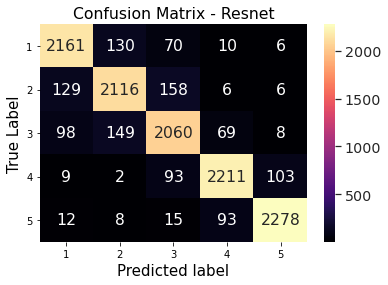

<Figure size 720x504 with 0 Axes>

In [ ]:
#import the relevant packages
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

labels = ['1', '2', '3', '4', '5'] #Check thiss

#turn this into a dataframe
matrix_df = pd.DataFrame(confusion_mtx)
#plot the result
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
#set axis titles
ax.set_title('Confusion Matrix - Resnet')
ax.set_xlabel("Predicted label", fontsize =15)
ax.set_xticklabels(labels)
ax.set_ylabel("True Label", fontsize=15)
ax.set_yticklabels(list(labels), rotation = 0)
plt.show()

In [ ]:
print(metrics.classification_report((y_test+1),(Y_pred_classes+1)))

              precision    recall  f1-score   support

           1       0.90      0.91      0.90      2377
           2       0.88      0.88      0.88      2415
           3       0.86      0.86      0.86      2384
           4       0.93      0.91      0.92      2418
           5       0.95      0.95      0.95      2406

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



In [ ]:
Y_pred_classes

array([4, 2, 3, ..., 1, 3, 3])

In [ ]:
my_submission = pd.DataFrame({'id': testdata['id'], 'target': y_test1})
my_submission.to_csv('submission_mnist-01.csv', index=False)

NameError: ignored

https://www.youtube.com/watch?v=lOZGYzTn9Z8

https://github.com/Coderx7/SimpleNet_Pytorch/tree/5d13ddbba6ae531ced26469c6b0f0ec18665d5ec

https://www.youtube.com/results?search_query=fashion+mnist+keras

https://github.com/markjay4k/Fashion-MNIST-with-Keras/blob/master/pt%204%20-%20Deeper%20CNNs.ipynb

https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_3_resnet.ipynb

https://www.youtube.com/watch?v=sAzL4XMke80

https://stackoverflow.com/questions/44151760/received-a-label-value-of-1-which-is-outside-the-valid-range-of-0-1-python


